# Predicting the Senate expenditure in the first months of 2022

In [2]:
import numpy as np
import pandas as pd

In [3]:
#Prepare time series with total expenditure for each month for all years
Years = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

expenditures = []
date_index = []
for year in Years:
    dfYear = pd.read_csv('./CEAPS_Data/despesa_ceaps_' + year + '.csv', skiprows = 0, header = 1, sep = ';', encoding = 'latin-1', decimal = ',')[['ANO', 'MES', 'VALOR_REEMBOLSADO']]
    #Verify if year is correct in all rows
    year_values = dfYear['ANO'].unique()
    if len(year_values) != 1:
        print("Error in year column:", year)
        
    months = np.sort(dfYear['MES'].unique())
    
    Month_Sum = dfYear.groupby('MES')['VALOR_REEMBOLSADO'].sum()
    for month in months:
        expenditures.append(Month_Sum.get(month))
        if month < 10:
            month = '0' + str(month)
        else:
            month = str(month)
        date_index.append(month + "/" + str(year))
        

ExpenditureSeries = pd.Series(expenditures, index = date_index)    

In [4]:
pd.set_option('display.max_rows', None) #Apresenta todas as linhas
ExpenditureSeries

02/2008     900507.98
03/2008    1064673.39
04/2008    1032569.59
05/2008     918064.51
06/2008     922815.50
07/2008     938308.25
08/2008    1047746.07
09/2008     968794.52
10/2008    1035147.45
11/2008    1179898.50
12/2008    1567421.64
01/2009     911284.92
02/2009     973690.42
03/2009     915849.11
04/2009     864594.44
05/2009     897612.81
06/2009     879017.97
07/2009     895243.68
08/2009     921076.94
09/2009     970208.00
10/2009    1018413.71
11/2009    1149436.24
12/2009    1335458.02
01/2010     797009.90
02/2010     836040.72
03/2010    1077340.24
04/2010     900934.90
05/2010     897544.91
06/2010     830251.68
07/2010     801239.10
08/2010     624198.39
09/2010     612103.42
10/2010     815833.86
11/2010    1239798.38
12/2010    1327715.07
01/2011     637051.83
02/2011     742025.83
03/2011     949478.93
04/2011     956659.54
05/2011     992217.17
06/2011    1808702.49
07/2011    1738878.61
08/2011    2047082.77
09/2011    2088794.07
10/2011    2107203.49
11/2011   

<AxesSubplot:>

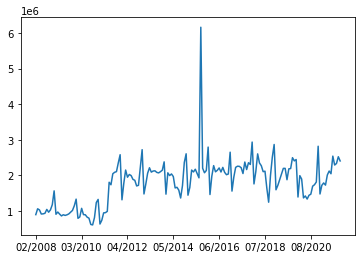

In [5]:
ExpenditureSeries.plot()

<AxesSubplot:>

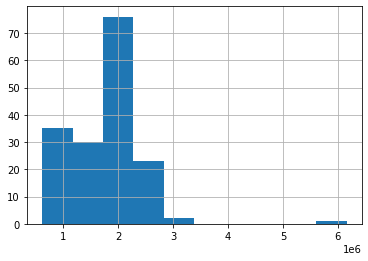

In [6]:
ExpenditureSeries.hist()

In [7]:
#Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller 

ADFTest = adfuller(ExpenditureSeries.values)
print('ADF statistics: ', ADFTest[0])
print('p-value: ', ADFTest[1])
print('Critical values:')
for key, value in ADFTest[4].items():
    print('\t',key, value)

ADF statistics:  -2.524310278232437
p-value:  0.10967085248442981
Critical values:
	 1% -3.471118535474365
	 5% -2.8794405060097024
	 10% -2.576313761526591


In [8]:
#Take the first differences of the series.
#Subtract the value of one month by the value of the same month in the previous year.
#From 02/2009 to 12/2021.
Years = ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
Months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

values = []
dates = []
for year in Years:
    for month in Months:
        if month == '01' and year == '2009':
            continue
        date = month + '/' + year
        pastdate = month + '/' + str(int(year) - 1)
        values.append(ExpenditureSeries.get(date) - ExpenditureSeries.get(pastdate))
        dates.append(date)

FirstDifferenceSeries = pd.Series(values, index = dates) 

ADFTest = adfuller(FirstDifferenceSeries.values)
print('ADF statistics: ', ADFTest[0])
print('p-value: ', ADFTest[1])
print('Critical values:')
for key, value in ADFTest[4].items():
    print('\t',key, value)

ADF statistics:  -4.357559242532411
p-value:  0.00035259897044648996
Critical values:
	 1% -3.477261624048995
	 5% -2.8821181874544233
	 10% -2.5777431104939494


**Now we have a stationary time series.**

In [9]:
#Function for the inverse transformation
def InverseFirstDifference(FDSeries):
    #Get the values for 2008
    InverseSeries = pd.Series(ExpenditureSeries.iloc[:12].values, index = ['02/2008', '03/2008', '04/2008', '05/2008', '06/2008', '07/2008', '08/2008', '09/2008', '10/2008', '11/2008', '12/2008', '01/2009'])
    
    for key in FDSeries.keys():
        month, year = key.split('/')
        pastkey = month + '/' + str(int(year) - 1)
        InverseValue = FDSeries.get(key) + InverseSeries.get(pastkey)
        
        InverseSeries = pd.concat([InverseSeries, pd.Series([InverseValue], index = [key])])
        
    return InverseSeries
    

#print(InverseFirstDifference(FirstDifferenceSeries))
#print(ExpenditureSeries.subtract(InverseFirstDifference(FirstDifferenceSeries)))

<AxesSubplot:>

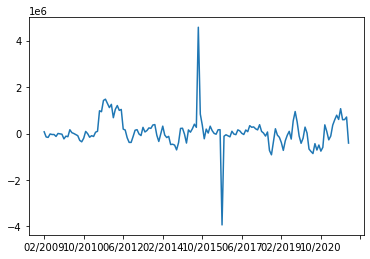

In [10]:
FirstDifferenceSeries.plot()

<AxesSubplot:>

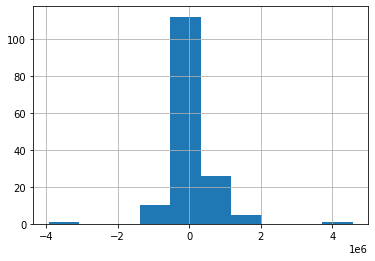

In [11]:
FirstDifferenceSeries.hist()

In [12]:
#Calculate the mean expenditure for each month.
#This will be used as baseline for the models.
Means = np.full((12), 0.0)
for date, value in ExpenditureSeries.items():
    month = date.split("/")[0]
    Means[int(month) - 1] += value

print('Means: ')
for i in range(12):
    print('\t',i + 1,": ",Means[i])

Means: 
	 1 :  17325438.360000003
	 2 :  22205358.77999999
	 3 :  25048414.05000001
	 4 :  23910379.809999973
	 5 :  24279522.219999976
	 6 :  24460098.64999998
	 7 :  23636424.40999999
	 8 :  28787923.140000004
	 9 :  23675766.92000001
	 10 :  25550686.079999987
	 11 :  28413403.30999997
	 12 :  33455918.579999983


## Facebook Prophet

In [13]:
from prophet import Prophet

In [14]:
#Prepare dataframe for the prophet algorithm
dfFBP = pd.DataFrame({'ds':FirstDifferenceSeries.index, 'y':FirstDifferenceSeries.values})
dfFBP

,ds,y
0,02/2009,73182.44
1,03/2009,-148824.28
2,04/2009,-167975.15
3,05/2009,-20451.70
4,06/2009,-43797.53
5,07/2009,-43064.57
6,08/2009,-126669.13
7,09/2009,1413.48
8,10/2009,-16733.74
9,11/2009,-30462.26


In [15]:
#Create and fit he model
FBP = Prophet(seasonality_mode='multiplicative')
FBP.fit(dfFBP)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


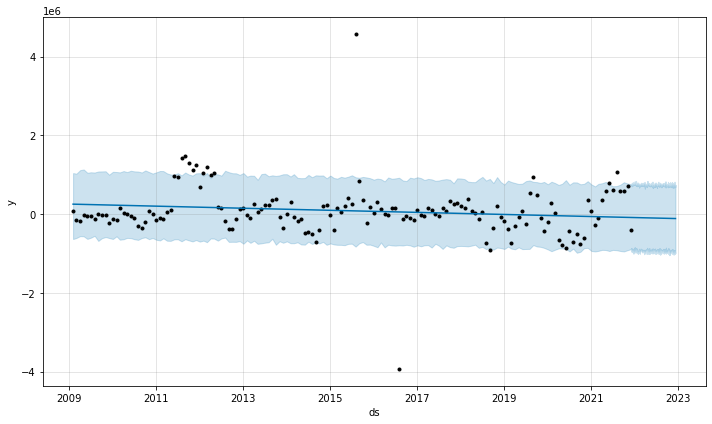

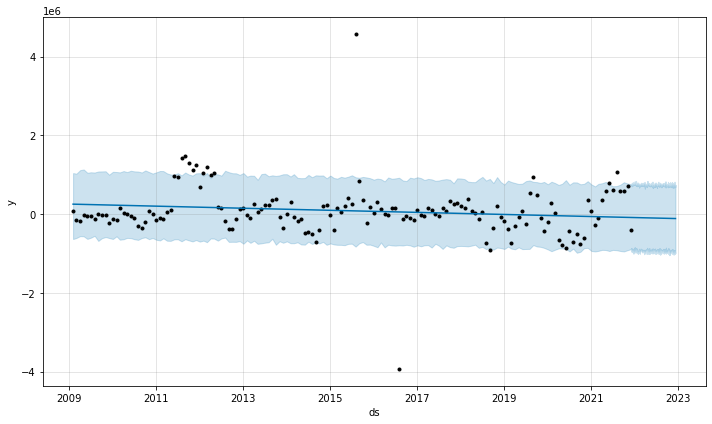

In [30]:
#Preditions
Months_to_predict = 12
future = FBP.make_future_dataframe(periods=31*Months_to_predict)
predictions = FBP.predict(future)
FBP.plot(predictions)

In [31]:
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2009-02-01,254028.560570,-6.319618e+05,1.043943e+06,254028.560570,254028.560570,0.000487,0.000487,0.000487,0.000487,0.000487,0.000487,0.0,0.0,0.0,254152.267199
1,2009-03-01,251956.767851,-6.048300e+05,1.028582e+06,251956.767851,251956.767851,0.001157,0.001157,0.001157,0.001157,0.001157,0.001157,0.0,0.0,0.0,252248.276273
2,2009-04-01,249662.997340,-5.583171e+05,1.117623e+06,249662.997340,249662.997340,-0.000185,-0.000185,-0.000185,-0.000185,-0.000185,-0.000185,0.0,0.0,0.0,249616.884040
3,2009-05-01,247443.219427,-5.611344e+05,1.136010e+06,247443.219427,247443.219427,0.000102,0.000102,0.000102,0.000102,0.000102,0.000102,0.0,0.0,0.0,247468.503040
4,2009-06-01,245149.448916,-6.281040e+05,1.052418e+06,245149.448916,245149.448916,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.0,0.0,0.0,245161.983945
5,2009-07-01,242929.671002,-5.974349e+05,1.064104e+06,242929.671002,242929.671002,-0.000355,-0.000355,-0.000355,-0.000355,-0.000355,-0.000355,0.0,0.0,0.0,242843.334812
6,2009-08-01,240696.715103,-5.498054e+05,1.058100e+06,240696.715103,240696.715103,0.001193,0.001193,0.001193,0.001193,0.001193,0.001193,0.0,0.0,0.0,240983.861845
7,2009-09-01,238463.759203,-6.796480e+05,1.084301e+06,238463.759203,238463.759203,-0.000972,-0.000972,-0.000972,-0.000972,-0.000972,-0.000972,0.0,0.0,0.0,238232.068267
8,2009-10-01,236302.834140,-6.103635e+05,1.086074e+06,236302.834140,236302.834140,-0.000560,-0.000560,-0.000560,-0.000560,-0.000560,-0.000560,0.0,0.0,0.0,236170.515198
9,2009-11-01,234069.878240,-5.813434e+05,1.089563e+06,234069.878240,234069.878240,-0.000775,-0.000775,-0.000775,-0.000775,-0.000775,-0.000775,0.0,0.0,0.0,233888.369731


In [32]:
#Get only data with ds in the form YY-MM-01

date_indexes = []
values = []

for i in range(predictions.shape[0]):
    date, value = predictions.loc[i, ['ds', 'yhat']].values
    date = str(date).split(" ")[0]
    year, month, day = date.split("-")
    
    if day == '01':
        date_indexes.append(month + '/' + year)
        values.append(value)

PredictedSeries = pd.Series(values, index = date_indexes)

In [33]:
PredictedSeries

02/2009    254152.267199
03/2009    252248.276273
04/2009    249616.884040
05/2009    247468.503040
06/2009    245161.983945
07/2009    242843.334812
08/2009    240983.861845
09/2009    238232.068267
10/2009    236170.515198
11/2009    233888.369731
12/2009    231871.549327
01/2010    229542.871803
02/2010    227568.139349
03/2010    225674.574929
04/2010    223149.528685
05/2010    221052.962869
06/2010    218815.750624
07/2010    216561.907919
08/2010    214665.239002
09/2010    211967.432327
10/2010    209888.640294
11/2010    207616.656878
12/2010    205580.453980
01/2011    203269.286693
02/2011    201274.948979
03/2011    199343.120962
04/2011    196861.399624
05/2011    194757.709934
06/2011    192527.196843
07/2011    190280.411637
08/2011    188345.455898
09/2011    185702.473564
10/2011    183608.061647
11/2011    181345.229602
12/2011    179290.497118
01/2012    176995.310714
02/2012    174978.333427
03/2012    172980.819545
04/2012    170509.209937
05/2012    168396.564814


In [34]:
InversePredictedSeries = InverseFirstDifference(PredictedSeries)

<AxesSubplot:>

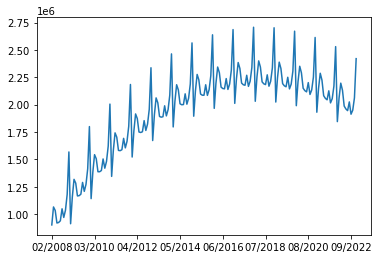

In [35]:
InversePredictedSeries.plot()

In [36]:
#Compare with the original values between 2008 and 2021
Years = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
Months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for year in Years:
    for month in Months:
        if month == '01' and year == '2008':
            continue
        original = round(ExpenditureSeries.get(month + '/' + year))
        predicted = round(InversePredictedSeries.get(month + '/' + year))
        
        print(month + '/' + year + ": ", original, predicted, original - predicted, (original - predicted)/original)

02/2008:  900508 900508 0 0.0
03/2008:  1064673 1064673 0 0.0
04/2008:  1032570 1032570 0 0.0
05/2008:  918065 918065 0 0.0
06/2008:  922816 922816 0 0.0
07/2008:  938308 938308 0 0.0
08/2008:  1047746 1047746 0 0.0
09/2008:  968795 968795 0 0.0
10/2008:  1035147 1035147 0 0.0
11/2008:  1179898 1179898 0 0.0
12/2008:  1567422 1567422 0 0.0
01/2009:  911285 911285 0 0.0
02/2009:  973690 1154660 -180970 -0.18585997596771045
03/2009:  915849 1316922 -401073 -0.43792481074937023
04/2009:  864594 1282186 -417592 -0.48299201706234374
05/2009:  897613 1165533 -267920 -0.29848052557171073
06/2009:  879018 1167977 -288959 -0.32872933205008315
07/2009:  895244 1181152 -285908 -0.31936321271072465
08/2009:  921077 1288730 -367653 -0.39915555377020595
09/2009:  970208 1207027 -236819 -0.24409095781523138
10/2009:  1018414 1271318 -252904 -0.24833122875372884
11/2009:  1149436 1413787 -264351 -0.2299832265563285
12/2009:  1335458 1799293 -463835 -0.3473227911323306
01/2010:  797010 1140828 -343818 

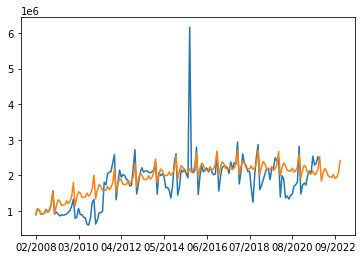

In [37]:
#Plot original and predicted series
import matplotlib.pyplot as plt
plt.figure()
ExpenditureSeries.plot()
InversePredictedSeries.plot()
plt.show()

In [49]:
#Show predicted values for 2022
Months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
for month in Months:
    print(month + '/2022: ', round(InversePredictedSeries.get(month + '/2022')))

01/2022:  1844659
02/2022:  2060077
03/2022:  2196355
04/2022:  2131451
05/2022:  1986952
06/2022:  1960348
07/2022:  1945110
08/2022:  2024821
09/2022:  1912523
10/2022:  1949017
11/2022:  2062350
12/2022:  2420164


In [51]:
#Get known values of 2022 and compare with predicted ones
#The know months are January, February and March (April is not complete).
df2022 = pd.read_csv('./CEAPS_Data/despesa_ceaps_2022.csv', skiprows = 0, header = 1, sep = ';', encoding = 'latin-1', decimal = ',')[['ANO', 'MES', 'VALOR_REEMBOLSADO']]
Month_Sum = df2022.groupby('MES')['VALOR_REEMBOLSADO'].sum()


for month in [1, 2, 3]:
    original = round(Month_Sum.get(month))
    predicted = round(InversePredictedSeries.get('0' + str(month) + '/2022'))
    print('Month 0' + str(month) + ": ", original, predicted, original - predicted, (original - predicted)/original)

Month 01:  1777494 1844659 -67165 -0.03778634414518418
Month 02:  2146455 2060077 86378 0.040242166735384624
Month 03:  2289803 2196355 93448 0.040810497671633764


In [48]:
Month_Sum.get(1)

1777494.1200000024

In [44]:
Month_Sum

MES
1    1777494.12
2    2146455.39
3    2289803.02
4     527006.26
Name: VALOR_REEMBOLSADO, dtype: float64